# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.
## TOC:
* [Setting up pheromone environment](#first-bullet)
* [Agent following Intrinsic policy](#second-bullet)
* [Shifting to OU-policy](#third-bullet)
* [Setting up reward dynamics](#fourth-bullet)
* [Laying pheromone after success](#fifth-bullet)

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any
import random as rm

import cmocean
import cmocean.cm as cmo
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="third-bullet">Shifting to OU-policy</a>

Dynamics of an agent following $\pi_{\rm int}$ for a distance and shifting to $\pi_{\rm OU}$ towards the target

In [3]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 60 #number of steps of each run
        self.nEpchs = 250 #number of epochs
        self.a = 1 #radius of semi-circle
        self.nIntSteps = int(0.25*self.nSteps) #number of steps of intrinsic policy
        
        # Pheromone parameters
        self.nMsh = 500 #number of points in 
        self.kM = 1 #rate of pheromone decay
        self.kP = 0.1 #rate of pheromone generation
        
        # Agent dynamics parameters
        self.pt = 0.05 #initial pheromone trail thickness
        self.sz = 0.02 #agent size (radius)
        self.dt = 1e-2 #time-step size
        self.l = 5e-2 #length travelled in 1 time-step
        self.vo = self.l/self.dt #effective speed of motion
        self.alpha = 50 #orientation relaxation rate (s^-1)
        self.diff = 50e-1 #noise diffusion coefficient
        
        self.rInit = np.array([self.a, 0.0]) #initial location of agent
        self.tgt = np.array([-self.a, 0.0]) #target location of agent
        self.thetInit = 0.5*np.pi #initial orientation of agent
        # self.rng = random.PRNGKey(1) #initial random number
        self.tgtPhi = 0.0 #target orientation from current location

# Pheromone initial condition and class
p = params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])

In [4]:
phm = phrmn(cInit)
# Agent class
class agent():
    global phm
    def __init__(self, p):
        super().__init__()
        self.r = p.rInit
        self.thet = p.thetInit
        # self.rng = p.rng
        
    def intPolicy(self, p):       
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r = self.r + p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        
        # cVal = phmChk(self.r, phm)
        # if ((1.0-cVal) < 1e-3):
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, p):
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.alpha*p.dt) + p.alpha*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()


In [5]:
ag = agent(p)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
for ind in range(p.nSteps):
    if ind < p.nIntSteps:
        ag.intPolicy(p)
    elif ind == p.nIntSteps:
        tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00831913948059082 seconds ---


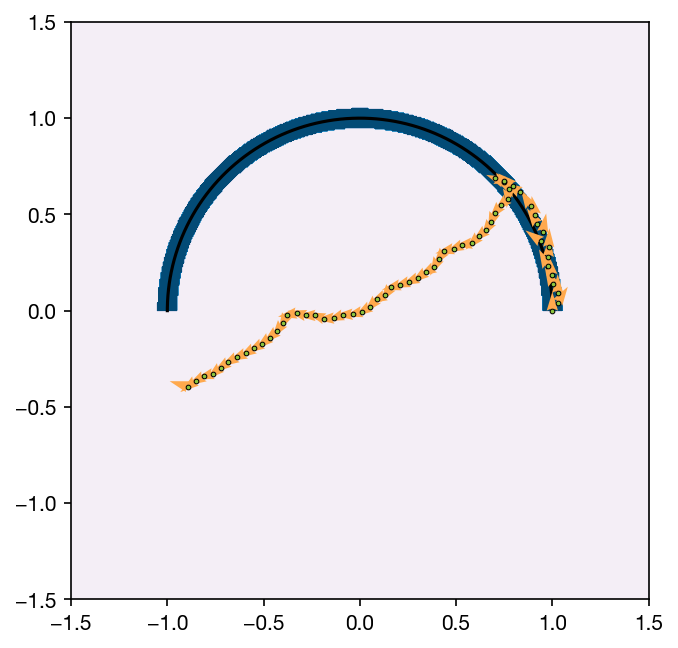

In [6]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(5, 5), dpi=150)
ax = plt.subplot(1, 1, 1, aspect=1)
ax.contourf(xphm, yphm, phm.c, cmap='PuBu')
thetPlt = np.linspace(0., np.pi, 200)
ax.plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='k', zorder=1)

ax.scatter(rxFull, ryFull,
            s=5,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=2)
ax.quiver(rxFull, ryFull,
           phxFull, phyFull,
           scale_units='xy',
           color=colors['orange'][4],
           scale=10.2)

ax.set_aspect(1)
plt.show()

--- 8.841758966445923 seconds ---


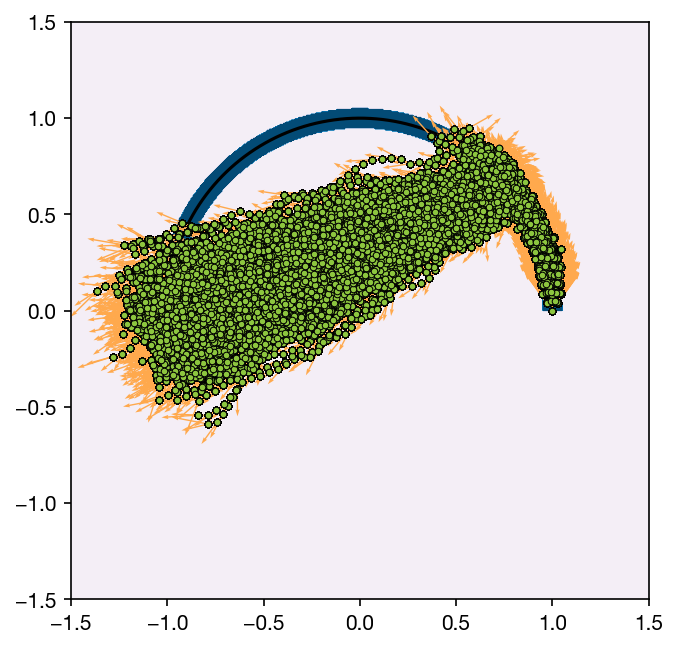

In [7]:
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")
linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = plt.subplot(1, 1, 1, aspect=1)

for eInd in range(p.nEpchs):
    ag = agent(p)
    for ind in range(p.nSteps):
        if ind < p.nIntSteps:
            ag.intPolicy(p)
        elif ind == p.nIntSteps:
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    
    
    ax.contourf(xphm, yphm, phm.c, cmap='PuBu')
    thetPlt = np.linspace(0., np.pi, 200)
    ax.plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='k', zorder=1)

    ax.scatter(rxFull, ryFull,
                s=10,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=2)
    ax.quiver(rxFull, ryFull,
            phxFull, phyFull,
            scale_units='xy',
            color=colors['orange'][4],
            scale=5.2)

    ax.set_aspect(1)
print("--- %s seconds ---" % (time.time() - start_time))
plt.show()

 ## <a class="anchor" id="fourth-bullet">Setting up reward dynamics</a>